# TensorFlow - GAN
## Eduardo Gomes Sanglard - IAA 2022
### Laboratório de Inteligência Artifical - Frameworks de IA

- GAN : Gerador de dígitos fake

Link para este notebook no Google Colab
https://drive.google.com/file/d/1ILuigWc-RanKXPd27VHbp1lShWf3b3Vz/view?usp=sharing

Instalação de Dependências

In [1]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-o41q173m
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-o41q173m
  Resolved https://github.com/tensorflow/docs to commit abfbe6e54864baa38dbb985b984acd304be610d4
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=183273 sha256=351f6cc9e7976b3a9713524254aacaba1227b295e7c57627abf13204b543b369
  Stored in directory: /tmp/pip-ephem-wheel-cache-wfmkh4tt/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [2]:
import tensorflow as tf
import glob, imageio, os, PIL, time
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
from IPython import display

Carregar os dados e pré-processar

In [3]:
# Carga, pré-processamento e separação
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images.shape

11490434/11490434 [==============================] - 2s 0us/step


(60000, 28, 28)

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Cria o gerador

In [5]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False,
    activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    return model

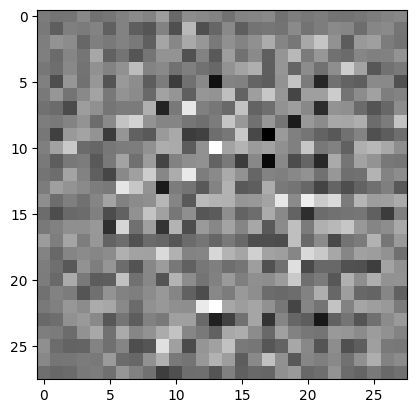

In [6]:
# teste de criação de uma imagem (sem treinar)
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [7]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
  input_shape=[28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  return model

In [8]:
# Teste do discriminador (não treinado)
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00145574]], shape=(1, 1), dtype=float32)


In [9]:
#Função de perda Binary Cross Entropy
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Quantifica quão bom é o discriminador
# Compara: predições de imagens reais com vetor de 1's
# Compara: predições de imagens fake com vetor de 0's
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

# Quantifica quão bem o gerador enganou o discriminador
# Se for bom, imagens fake serão classificadas com 1's
# Compara: predições fake com 1's
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

# Otimizador do gerador e discriminador
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [10]:
# Salvar pontos de verificação, caso a tarefa seja interrompida
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                  discriminator_optimizer=discriminator_optimizer,
                                  generator=generator,
                                  discriminator=discriminator)

In [11]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,  discriminator.trainable_variables))

In [12]:
def train(dataset, epochs):

  for epoch in range(epochs):
    
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produz as imagens para o GIF
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Salva a cada 15 épocas
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Gera depois da época final
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)


In [13]:
# Gerar e salvar imagens
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4, 4))
  
  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

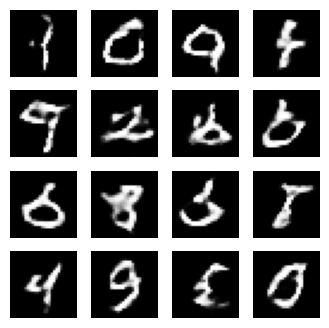

In [14]:
# Treinar o modelo
train(train_dataset, EPOCHS)
# restaurar o último ponto de verificação
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

<ipython-input-15-6e641891e4ce>:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-15-6e641891e4ce>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



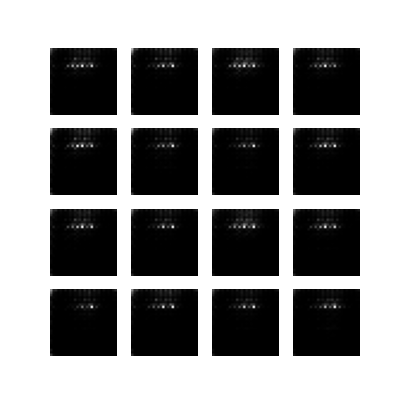

In [15]:
# Mostra uma imagem conforme a época
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)
# Gera e mostra o GIF
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
  
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)